# Group 42 Project Report : The Classification of Wine Quality

## Introduction

White wine is one of the oldest and most cherished alcoholic beverages known to humanity. It is not merely a drink; it is a wonderful interaction between flavors and aromas, a product of nature's alchemy and human craftsmanship that is commonly enjoyed before a meal, with dessert, or as a refreshing drink between meals. White wine is known for its light and refreshing taste, which sets it apart from many of its red wine counterparts. Due to its acidity and aroma, white wine is also useful in cooking, helping to soften meat and enhance the flavors of various dishes. The essence of white wine lies in its quality, a multifaceted concept that encompasses various chemical components and sensory attributes. 

This study delves into the complexity of wine quality, using a systematic approach to assess white wines on a scale of 3 to 9.  Our research focuses on 11 fundamental chemical properties: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, and quality. As each of these elements plays a crucial role in shaping the taste, aroma, and overall character of the wine, we would like to build a model to predict the value of wine quality by its properties.

This project uses the Wine Quality dataset of the white variant of the Portuguese "Vinho Verde" wine. This dataset contains 4898 observations of white wine with 12 attributes for each observation. This particular dataset contains no missing values.


#### Research question: Can a wine’s quality be accurately predicted on a scale of 3 to 9 based on its properties?

In [1]:
install.packages("kknn")
install.packages("caret")
library(tidyverse)
#library(repr)
library(tidymodels)
#library(rvest)
library(caret)
library(kknn)
install.packages("reactable")
library(reactable)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::di

## Methods and Results

##### The response variable we are looking for: 
- *Quality*

##### Procedure:
1. Read the data into R from the web
2. Clean and format the data into a tidy format
3. Summarize the data to find appropriate variables
4. Separate the data set into a training and test set
5. Perform cross-validation in order to determine the K-value to use for the classifier
6. Create the K-nearest neighbors classifier with the training set using the **tidymodels** package
7. Create a model and recipe, and train the classifier
8. Find the classifier’s accuracy

##### Visualization:
- A scatterplot will be used to first visualize the data set.
- A line graph can be used to visualize the accuracy of the classifier.


### 1. Read Data
Before we begin working with the data, we must load it into R from the web. The url for this dataset is https://archive.ics.uci.edu/static/public/186/wine+quality.zip.

In [2]:
url <- "https://raw.githubusercontent.com/RachelX6/DSCI100-Group-Project/main/winequality-white.csv"
white_wine_data <- read_delim(url, delim = ";") |>
        drop_na()

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Wrangling and Cleaning

In [3]:
colnames(white_wine_data) <- c("fixed_acidity", # Adjusting column names for clarity
              "volatile_acidity",
              "citric_acid",
              "residual_sugar",
              "chlorides",
              "free_sulfur_dioxide",
              "total_sulfur_dioxide",
              "density",
              "pH",
              "sulphates",
              "alcohol",
              "quality")

white_wine_data <- white_wine_data |>      # Converts the column "quality" into factor
    mutate(quality = as_factor(quality))
paste("Table 1. White Wine Data")
white_wine_data

[1] "Table 1. White Wine Data"

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.6,0.32,0.36,8.0,0.047,57,168,0.99490,3.15,0.46,9.6,5
6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


Above is the first five rows of the cleaned data.
A brief description of each column in the dataset is as follows:
- `fixed_acidity` -> The mass of fixed acid in the wine (g(tartaric acid)/dm$^{3}$).
- `volatile_acidity` -> The mass of volatile acid in the wine (g(acetic acid)/dm$^{3}$).
- `citric_acid` -> The mass of citric acid in the wine (g/dm$^{3}$).
- `residual_sugar` -> The mass of residual sugar in the wine (g/dm$^{3}$).
- `chlorides` -> The mass of chlorides in the wine (g(sodium chloride)/dm$^{3}$).
- `free_sulfur_dioxide` -> The mass of free sulfur dioxide in the wine (mg/dm$^{3}$).
- `total_sulfur_dioxide` -> The mass of total sulfur dioxide in the wine (mg/dm$^{3}$).
- `density` -> The overall density of the wine (g/cm$^{3}$).
- `pH` -> The pH of the wine (1-14).
- `sulphates` -> The mass of sulphates in the wine (g(potassium sulphate)/dm$^{3}$).
- `alcohol` -> The volume % alcohol content of the wine.

The last column, `quality`, is a rating on a scale from 3 to 9 of the wine's determined quality based on the given physicochemical factors.

In [4]:
set.seed(420)
# Creating the training and testing split of the data
wine_split_initial <- initial_split(white_wine_data, prop = .75, strata = quality)
wine_train_initial <- training(wine_split_initial)
wine_test_initial <- testing(wine_split_initial)

### 3. Summarizing the Data
To summarize our training data, we will: 
1. count the number of observations for each quality of wine
2. calculate the mean of each predictor for each quality.

Note: There are no missing values.

In [5]:
# Count the number of observations
wine_qual_counts <- wine_train_initial |>
            group_by(quality) |>
            summarize(count = n())
paste("Table 2. Wine Quality Count")
wine_qual_counts

[1] "Table 2. Wine Quality Count"

quality,count
<fct>,<int>
3,16
4,130
5,1082
6,1649
7,662
8,130
9,3


In Table 2, column `count` represents the number of distinct observations for each wine `quality`. From the table, there are a total of 3672 observations for white wines of qualities of 3 through 9. However, there are a significantly larger amount of observations designated to classes 5 to 7 as compared to the more extreme wine qualities (3-4 and 8-9). This signifies that there is a **class imbalance** in the data set, which is something we need to deal with before continuing with the actual model. Let's take a step back and use the oversampling method to synthetically fix this class imbalance across the entire data set.

In [6]:
set.seed(420)
# Using the caret package's "upSample" function :
wine_up <- upSample(white_wine_data[,-12], white_wine_data$quality, yname = "quality")
wine_up_counts <- wine_up |>
            group_by(quality) |>
            summarize(count = n())
wine_up_counts

quality,count
<fct>,<int>
3,2198
4,2198
5,2198
6,2198
7,2198
8,2198
9,2198


Here we can see that each of the qualities in the data set have now been filled with synthetic data points that were made by randomly sampling data near the actual values with replacement. It is important that we do this with the entire data set, rather than with just the training data as we want to fix the imbalance for the whole data set so that we can proceed to take a new split that has balanced data. 

Note that oversampling can potentially lead to an inaccurate data analysis because of the created data not matching what the real values should be.

With this new balanced data set, we can create a new split of training and testing data.

In [7]:
set.seed(420)
wine_split <- initial_split(wine_up, prop = .75, strata = quality)     # Creating and designation the new training and testing data sets.
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

In [8]:
wine_up_counts <- wine_train |>
            group_by(quality) |>
            summarize(count = n())
paste("Table 3. Training Data Counts")
wine_up_counts

[1] "Table 3. Training Data Counts"

quality,count
<fct>,<int>
3,1648
4,1648
5,1648
6,1648
7,1648
8,1648
9,1648


quality,count
<fct>,<int>
3,550
4,550
5,550
6,550
7,550
8,550
9,550


Each of the wine qualities in the training set now have 1648 observations, meaning that the data set is balanced and can be used in a clean data analysis.

In [9]:
wine_samp_m <- wine_train |>
    group_by(quality) |>
    summarize(across(everything(), list(mean)))
paste("Table 4. Means of Each Predictor")
wine_samp_m

[1] "Table 4. Means of Each Predictor"

quality,fixed_acidity_1,volatile_acidity_1,citric_acid_1,residual_sugar_1,chlorides_1,free_sulfur_dioxide_1,total_sulfur_dioxide_1,density_1,pH_1,sulphates_1,alcohol_1
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.628216,0.3340989,0.3382646,6.498877,0.05431917,52.80765,169.3544,0.9948976,3.181863,0.4703398,10.352306
4,7.166080,0.3755309,0.3071784,4.647725,0.04940655,22.96299,123.4317,0.9943019,3.179745,0.4763714,10.150850
5,6.922967,0.3005158,0.3361711,7.255097,0.05224333,36.46511,149.8438,0.9952140,3.173447,0.4820024,9.832421
6,6.841960,0.2598574,0.3389017,6.382585,0.04487561,35.57373,136.8896,0.9939232,3.188459,0.4920146,10.585862
7,6.743265,0.2607828,0.3269235,5.236044,0.03819114,34.36135,125.4120,0.9924718,3.210249,0.5072451,11.367692
8,6.604126,0.2782615,0.3226820,5.571268,0.03807706,37.00303,125.5589,0.9921509,3.222907,0.4923908,11.662621
9,7.401335,0.2984769,0.3845146,4.061893,0.02722148,33.89078,116.4666,0.9913842,3.307227,0.4634284,12.205583


In Table 4, columns 2-12 represents the mean value of the each variable for each quality. This can help us to do the summarized visualization in the next section as we can use the data above to see whether there is a strong relationship between each variable and the quality of wine.

### 4. Visualizing the Data

In [10]:
wine_plots <- wine_samp_m |>
    pivot_longer(cols = fixed_acidity_1:alcohol_1,
                 names_to = "predictor",
                 values_to = "value")

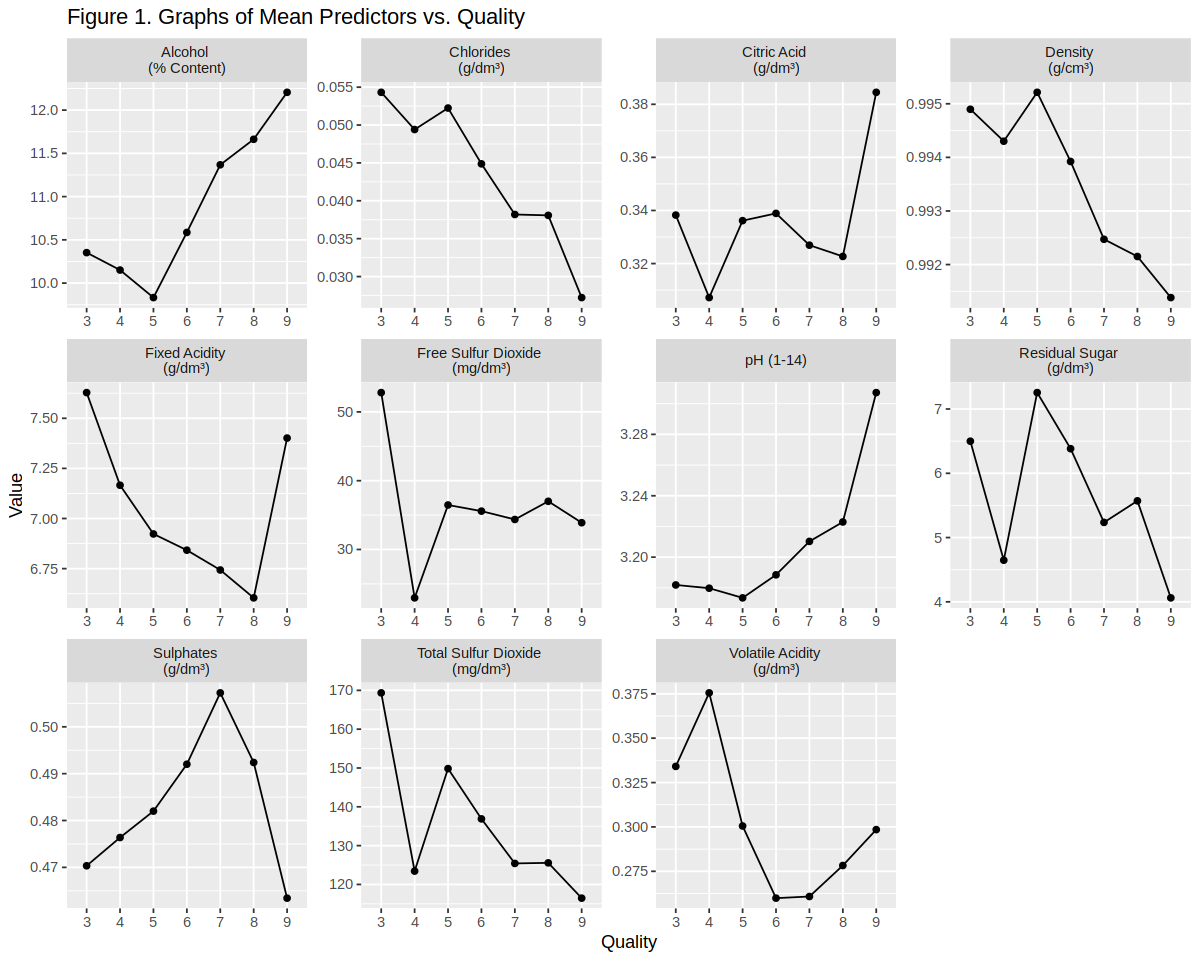

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)
labels <- c(alcohol_1 = "Alcohol \n(% Content)", 
                   chlorides_1 = "Chlorides \n(g/dm³)", 
                   citric_acid_1 = "Citric Acid \n(g/dm³)",
                   density_1 = "Density \n(g/cm³)", 
                   fixed_acidity_1 = "Fixed Acidity \n(g/dm³)",
                   free_sulfur_dioxide_1 = "Free Sulfur Dioxide \n(mg/dm³)",
                   pH_1 = "pH (1-14)",
                   residual_sugar_1 = "Residual Sugar \n(g/dm³)",
                   sulphates_1 = "Sulphates \n(g/dm³)",
                   total_sulfur_dioxide_1 = "Total Sulfur Dioxide \n(mg/dm³)",
                   volatile_acidity_1 = "Volatile Acidity \n(g/dm³)")
ggplot(wine_plots, aes(x = quality, y = value)) +
    geom_point() +
    geom_line(aes(group = 1)) +
    facet_wrap(facets = vars(predictor), scales = "free", labeller = labeller(predictor = labels)) +
    labs(x = "Quality", y = "Value") +
    ggtitle("Figure 1. Graphs of Mean Predictors vs. Quality")

Clearly there is quite a lot of information here, and it is not exactly easy and accurate to draw conclusions from simply looking at these visualizations. For example, in the mean `fixed_acidity` and `sulphates` graphs, the values do not have a distinct increasing or decreasing trend as the quality increases.

### 5. Forward Selection (Choosing Variables to Consider in Analysis)

In order to obtain the highest accuracy for our model, we will be using forward selection to find the best set of predictors to use. These predictors will be those that have the greatest contribution to deciding the quality of white wine, and when used together, will help derive the model with the highest accuracy. 

Forward selection starts by selecting one predictor, and records an estimated accuracy. It then continues to add one parameter for each step, forming a new set each time a predictor is added. This will help find the set of predictors that optimizes the accuracy when used in the model.

In [ ]:
names <- colnames(wine_train |> select(-quality))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        wine_recipe <- recipe(as.formula(model_string), 
                                data = wine_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(wine_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = wine_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
print("Table 5. Accuracies of Predictor Combinations")
accuracies

From the table above, the highest accuracy is when the size is 11. Although from size 4 onwards, there is only a very minimal increase in accuracy, which suggests that the predictors in size 4 (density, free sulfur dioxide, citric acid and residual sugar) are the most meaningful predictors, we will use all the varaibles as the predictors for our model since these predictors result in essentially the highest accuracy value on the table, with a value of 0.924.

### 6. Data Analysis

In [ ]:
set.seed(420) 

options(repr.plot.height = 5, repr.plot.width = 6)

wine_recipe <- recipe(quality ~ ., data = wine_train)

knn_spec <- nearest_neighbor(weight_func = "rectangular", # These two things we can remove for the final, I'm just putting them here for now so I don't have to run the cell above
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

grid_vals <- tibble(neighbors = seq(from = 2, to = 8))      

# We can use the previously created model and vfold from the forward selection step

wine_workflow <- workflow() |>
        add_recipe(wine_recipe) |>
        add_model(knn_spec) |>
        tune_grid(resamples = wine_vfold, grid = grid_vals) |>
        collect_metrics()

accuracy <- wine_workflow |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Figure 2. Estimated Accuracy vs. Number of Neighbors")

cross_val_plot

From Figure 2, we can see that when `k = 2` the classifier has the highest accuracy. Therefore, we choose `k = 2` as the number of neighbors.

In [ ]:
set.seed(420) 

#Create model using the best k
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
        set_engine("kknn") |>
        set_mode("classification")

#Fit the training data
wine_fit <- workflow() |>
    add_model(tuned_spec) |>
    add_recipe(wine_recipe) |>
    fit(wine_train)


In [ ]:
predict <- predict(wine_fit, wine_test_initial) |>  #testing accuracy of model on testing set
    bind_cols(wine_test_initial)
predict

In [ ]:
prediction_accuracy <- predict |>  
        metrics(truth = quality, estimate = .pred_class) |>
        filter(.metric == "accuracy")
print("Table 6. Prediction Accuracy")
prediction_accuracy

### 7. Discussion
Through our in-depth data analysis, we observed that density, free sulfur dioxide, citric acid, and residual sugar exhibited relatively superior performance as chosen variables. However, every variable within the wine exerted some influence on its quality, contributing to an enhanced predictability of overall wine quality. Concurrently, our initial investigation revealed a substantial disparity in the real-life distribution of wines, with a prevalence of medium-quality wines (quality 5-7) compared to the high-quality (8-10) or low-quality (1-4) counterparts.  This initial imbalance significantly impacted the accuracy of our model. Hence, we addressed this class imbalance issue by using the oversampling method, which used synthetic data points to allow all wine qualities in the dataset to have the same number of observations. Ultimately, through the use of a knn classifier with a K value of 2, the model was able to achieve an accuracy of 94.3%.

These results matches with what we expected. First of all, in the realm of wine production, achieving exceptionally high-quality wines has inherent challenges and it's really rare. Nevertheless, manufacturers diligently strive to uphold the standard of their wines to secure greater commercial profits. Consequently, the number of low-quality wines also remains minimal. Our research aligns with this industry dynamic, revealing a prevelance of medium-quality wines. Meanwhile, our research results also prove that wine quality can be accurately predicted on a scale of 3 to 9 based on its properties, since our model accuracy is 94.3%, and we did find that there are variables that have more impacts on the wine quality which are density, free sulfur dioxide, citric acid, and residual sugar, although all other predictors play an crucial role in the prediction.

Our findings can have significant impacts on both the wine manufacturing industry and the broader wine market. For wine manufacturers, our insights offer a roadmap to enhance the quality of their products. Specifically, focusing more on monitoring the key substances such as density, free sulfur dioxide, citric acid and residual sugar during the wine-making process can yield wines with improved taste and fragrance. These findings also empower wine sellers to make informed decisions regarding the quality and pricing of their offerings, facilitating a nuanced understanding of why certain wines gain greater commercial success. Moreover, armed with knowledge about the substance content detailed on wine labels, consumers can more easily make informed choices, opting for high-quality wines that align with their preferences. 

Our discovery of the absence of a clear trend in the influence of a specific substance on wine quality highlights a critical gap in the quantification and data-driven evaluation of current standards. This prompts a new perspective for future wine researchers: how to establish standardized criteria for assessing wine quality, therefore fostering a more uniform and regulated wine sales market. Other than that, some more general questions regarding wine industry and market can also be focused: how can wine manufacturers find a balance between the quality and cost of the wines they make? How will using different variables/methods of making wine affect the wine quality?




### 8. Reference
